TASK 1

FORECASTING FINANCIAL INSTRUMENTS PRICES
WITH VECM AND ARIMA MODELS

The aim of the project is to compare accuracy of forecasts of prices of two cointegrated financial
instruments with VECM model and two independent univariate ARIMA models.

Find one cointegrated pair out of ten provided time series. There is more than one cointegrated
pair but you are supposed to find just one of them. If you found more than one pair, you can
choose any of them for further analysis.
• Build a bivariate VECM model for the identified pair and produce forecasts of prices of two
instruments for the out-of-sample period.
• Find separately for two instruments the most attractive univariate ARIMA models and produce
forecasts for the same out-of-sample period.
• Compare accuracy of forecasts of the prices using the ex-post forecast error measures.
• Prepare a short report on it.

About the sample:
Please consider the in-sample period of 575 observations and out-of-sample period of 25 observations.
Detailed grading rules:
The maximum number of points you can get for the project is 40. Detailed grading rules are as follows:
• For checking the cointegration between the chosen time series – 6 pts.
• For estimating VECM, interpreting the estimates along with commenting on model’s diagnostics
and calculating forecasts – 12 pts.
• For applying the Box-Jenkins procedure in aim of choosing best possible ARIMA models’
specifications along with calculating forecasts for both series separately – 12 pts.
• For comparing VECM model’s forecasts with ARIMAs alternatives – 5 pts.
• For the structure, order, transparency and clarity of the provided report as well as for using a form
of Jupyter notebook – 5 pts.

In [37]:
#Load Dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller, kpss
import itertools
import warnings
from statsmodels.tools.sm_exceptions import InterpolationWarning

Data Preparation

In [38]:
df = pd.read_csv('TSA_2025_project_data_1.csv', index_col=0, parse_dates=True)
print("head:")
print(df.head())

head:
                y1      y2      y3      y4      y5      y6      y7      y8  \
date                                                                         
2023-09-09  109.41  109.41  109.41  124.24  124.47  109.41  119.94  104.66   
2023-09-10  109.41  109.41  109.41  124.21  124.32  109.41  101.39  104.34   
2023-09-11  109.42  109.41  109.41  124.41  124.37  109.41   97.64  104.23   
2023-09-12  108.68  110.19  111.12  123.93  124.82  109.41   94.35  107.23   
2023-09-13  106.21  110.88  112.92  122.68  123.91  107.84   96.22  109.71   

                y9     y10  
date                        
2023-09-09  107.62  119.32  
2023-09-10  102.61  119.36  
2023-09-11   99.16  119.38  
2023-09-12  103.39  121.06  
2023-09-13  102.43  122.17  


In [39]:
print("dtypes:")
print(df.dtypes)

dtypes:
y1     float64
y2     float64
y3     float64
y4     float64
y5     float64
y6     float64
y7     float64
y8     float64
y9     float64
y10    float64
dtype: object


In [40]:
print("missing values:")
print(df.isnull().sum())

missing values:
y1     0
y2     0
y3     0
y4     0
y5     0
y6     0
y7     0
y8     0
y9     0
y10    0
dtype: int64


In [41]:
#Define Spilt Sample
insample =df.iloc[:575] #first 575 observations
outsample = df.iloc[575:] #last 25 observations

#print(f"In-sample shape: {insample.shape}")
#print(f"Out-of-sample shape: {outsample.shape}")

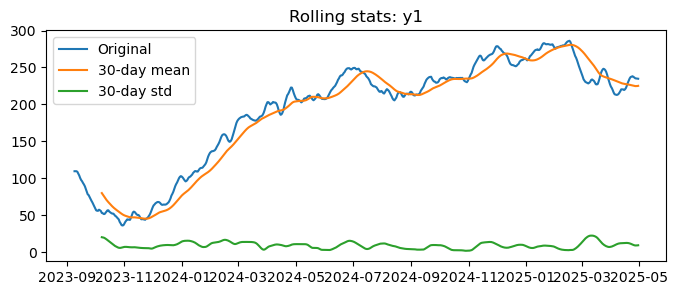

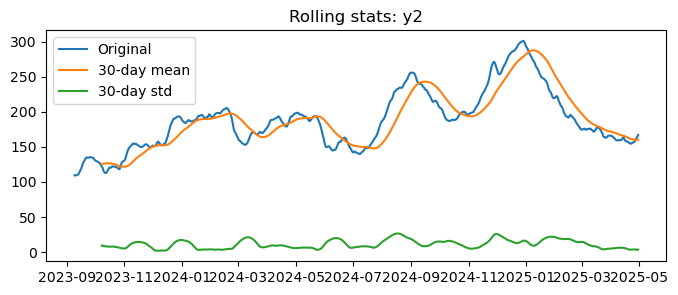

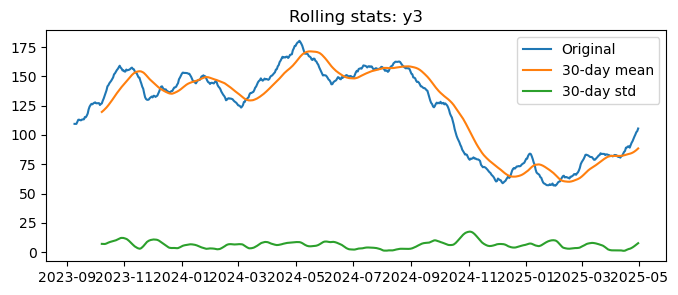

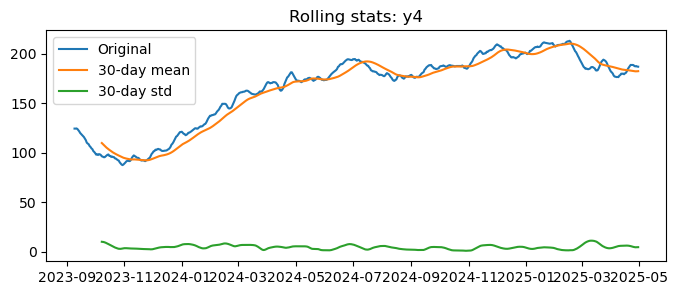

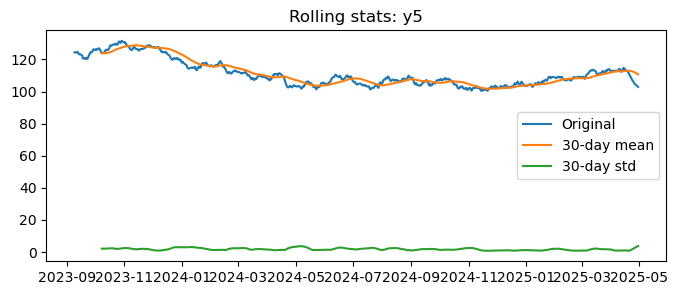

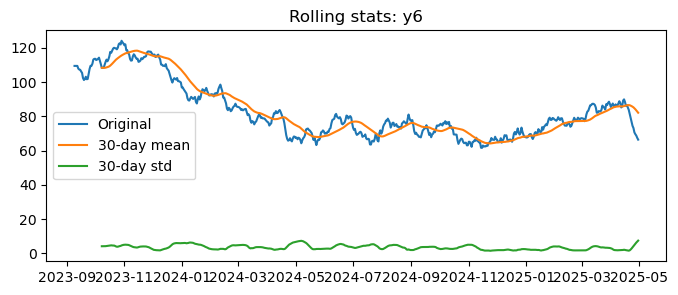

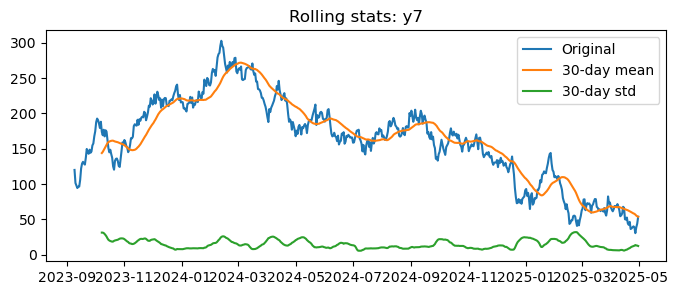

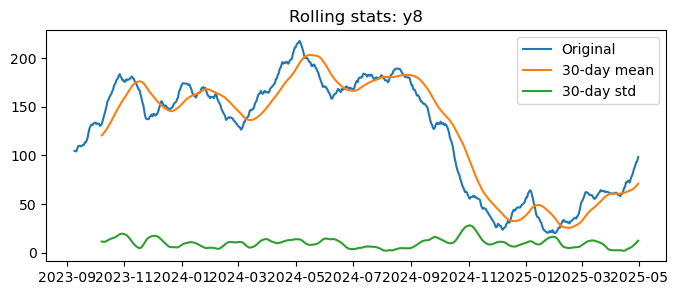

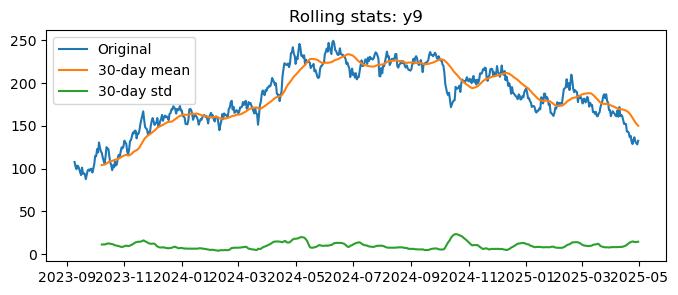

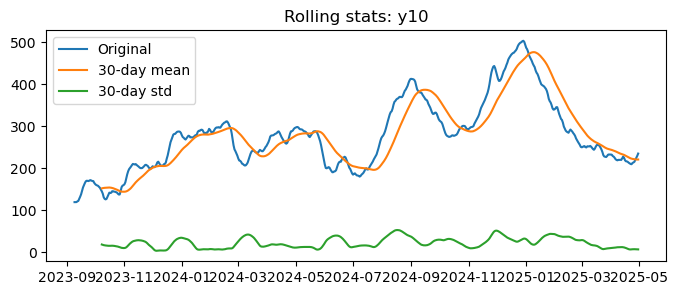

In [42]:
#30 day rolling mean and std
rolling_mean = df.rolling(window=30).mean()
rolling_std  = df.rolling(window=30).std()

for col in df.columns:
    plt.figure(figsize=(8,3))
    plt.plot(df.index, df[col],        label='Original')
    plt.plot(df.index, rolling_mean[col], label='30-day mean')
    plt.plot(df.index, rolling_std[col],  label='30-day std')
    plt.title(f'Rolling stats: {col}')
    plt.legend()
    plt.show()

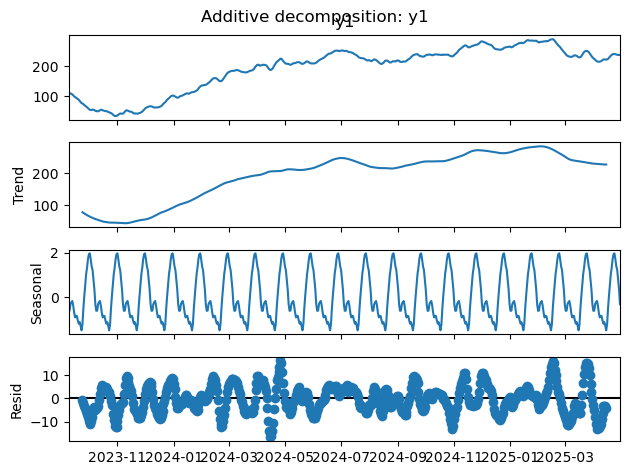

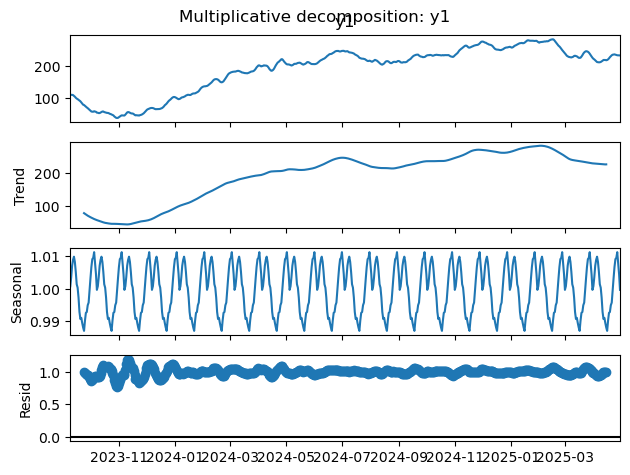

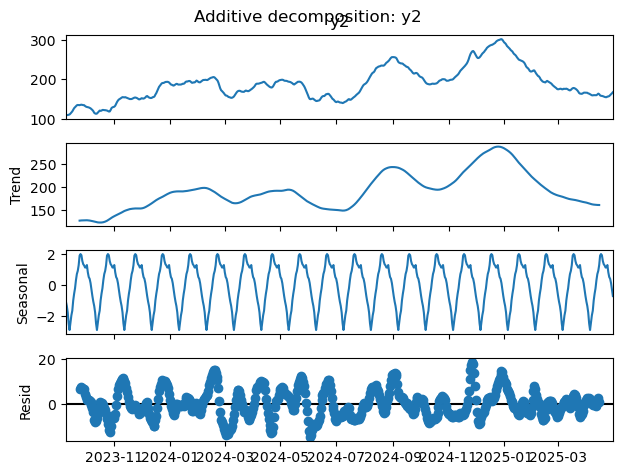

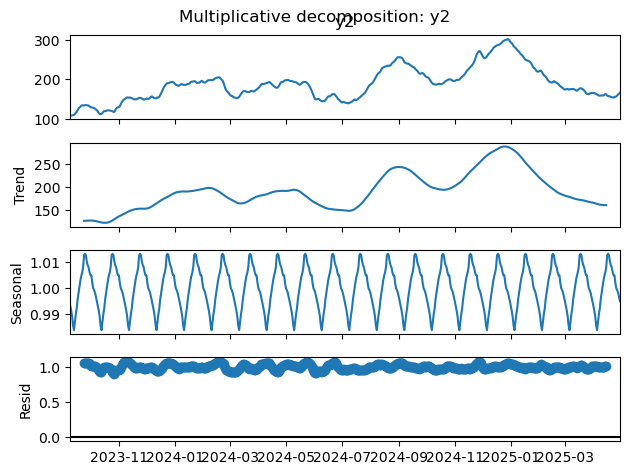

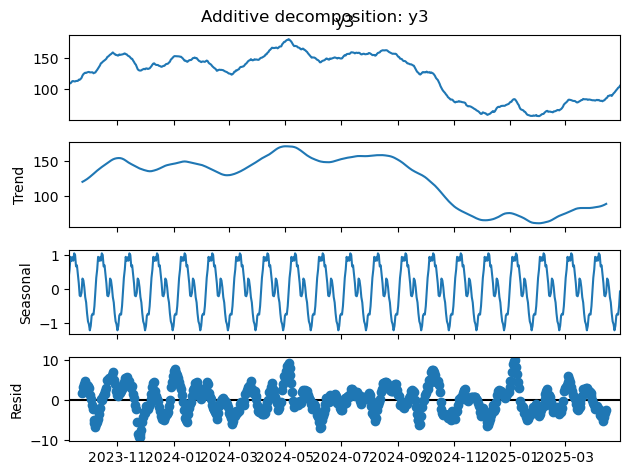

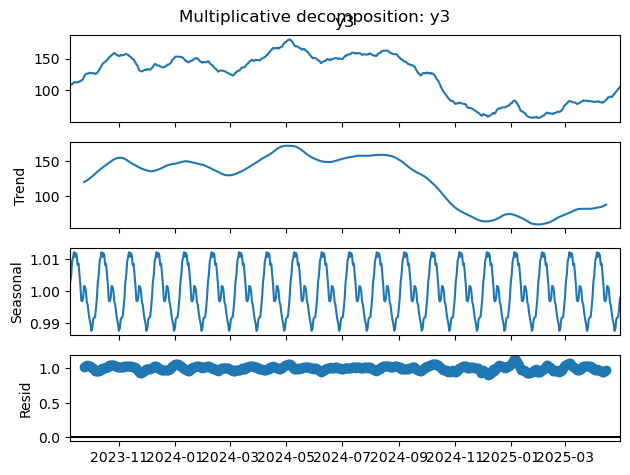

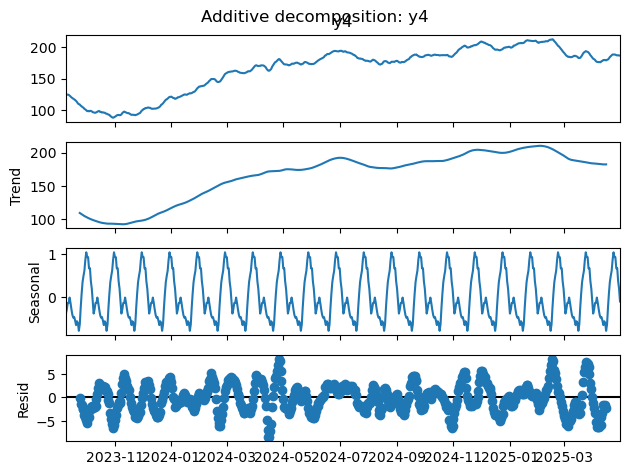

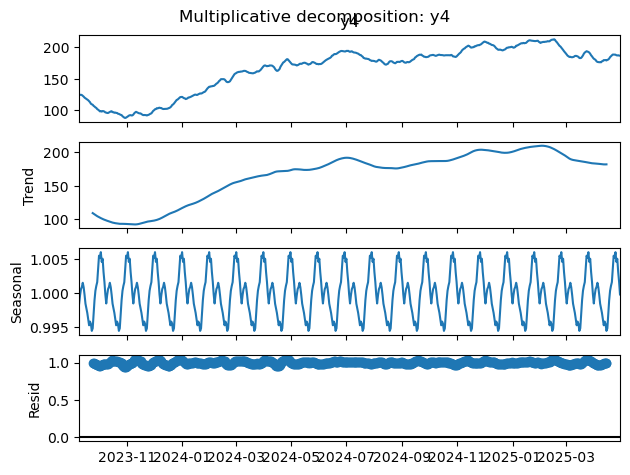

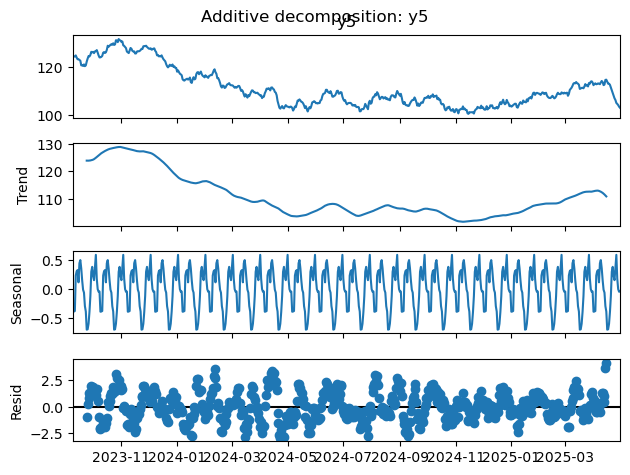

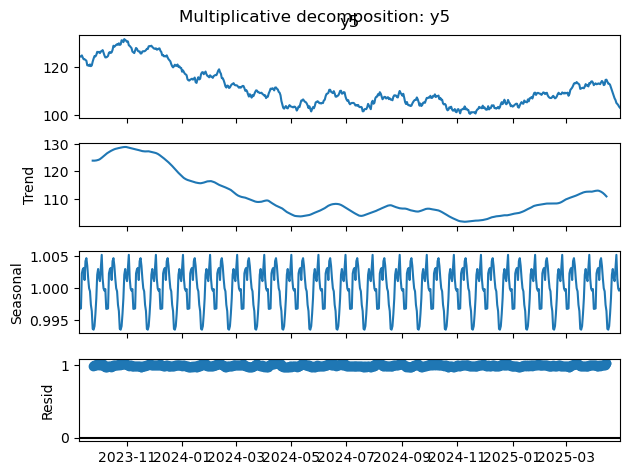

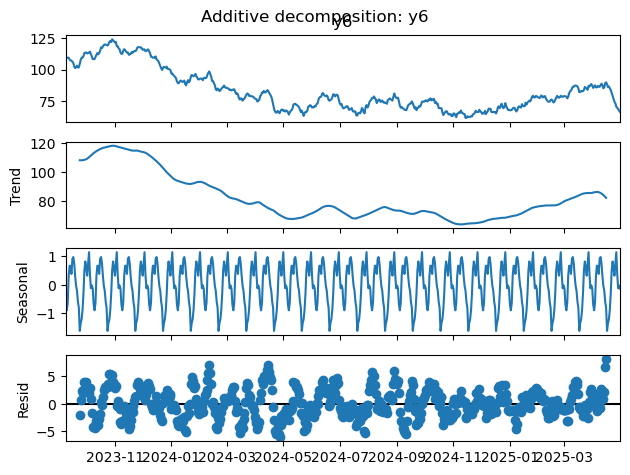

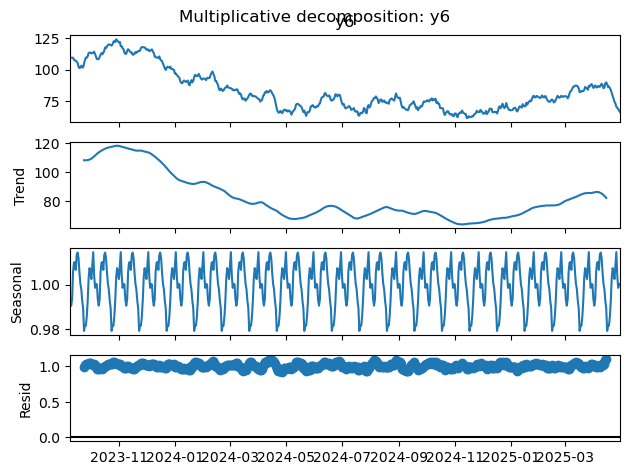

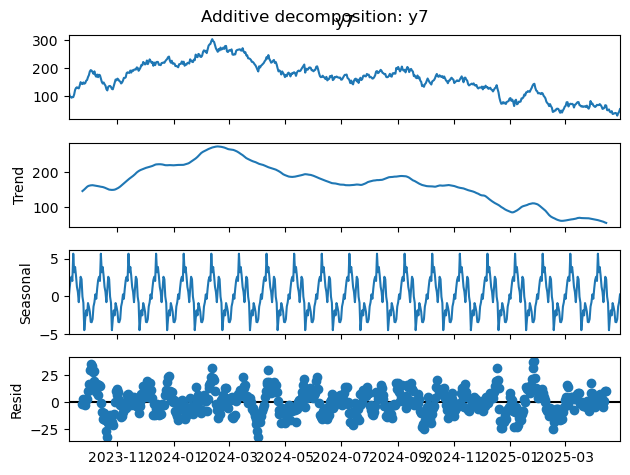

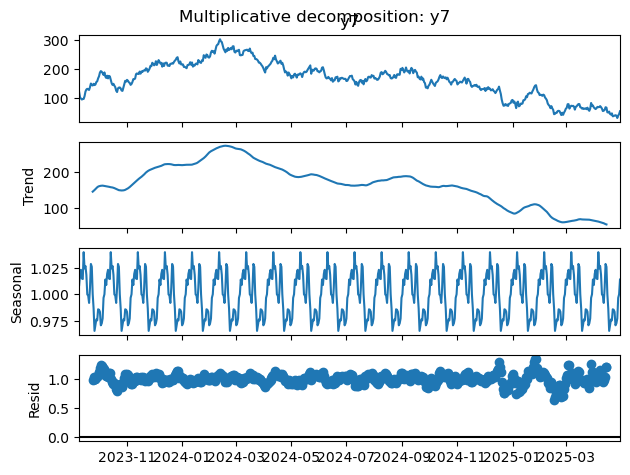

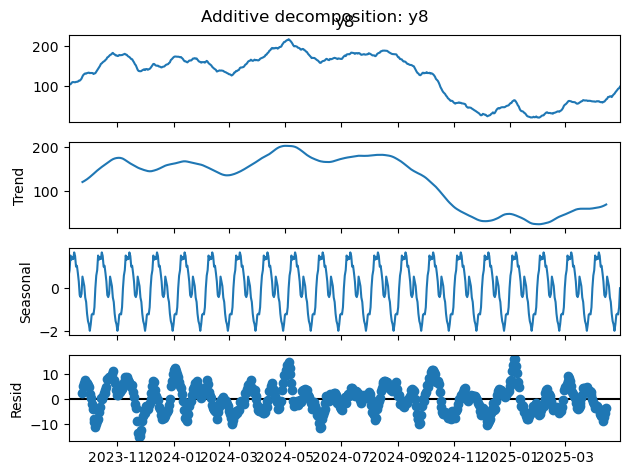

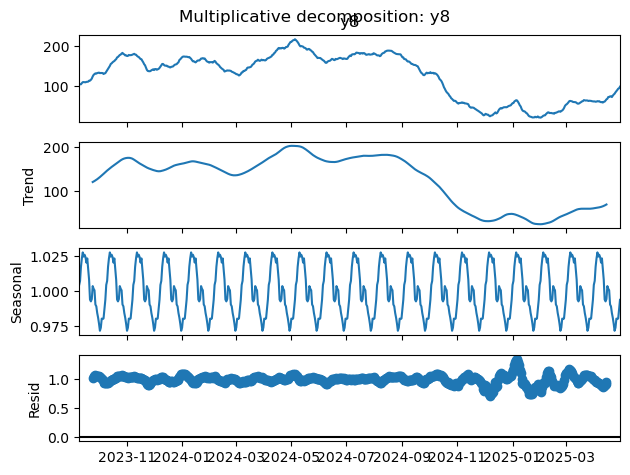

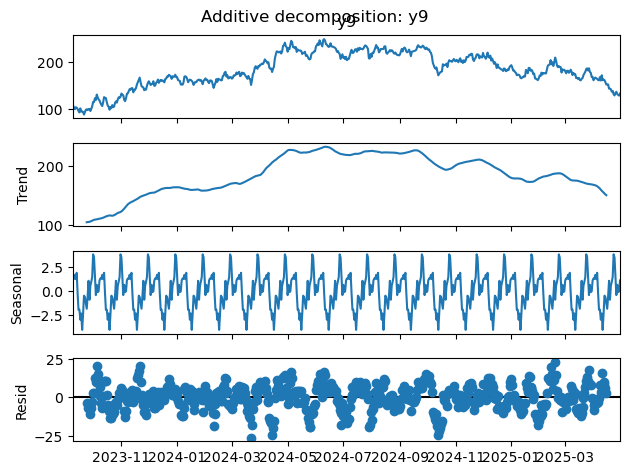

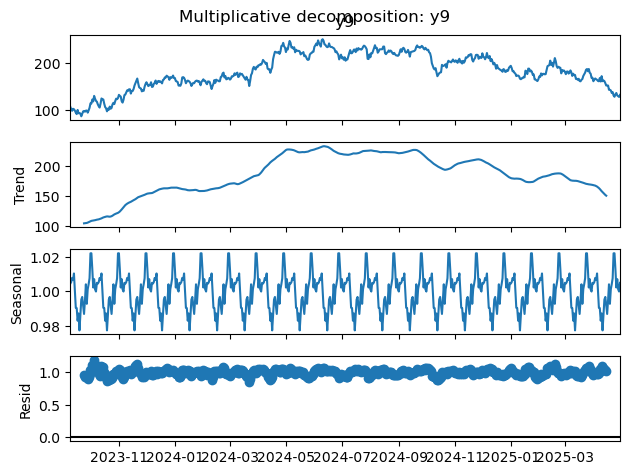

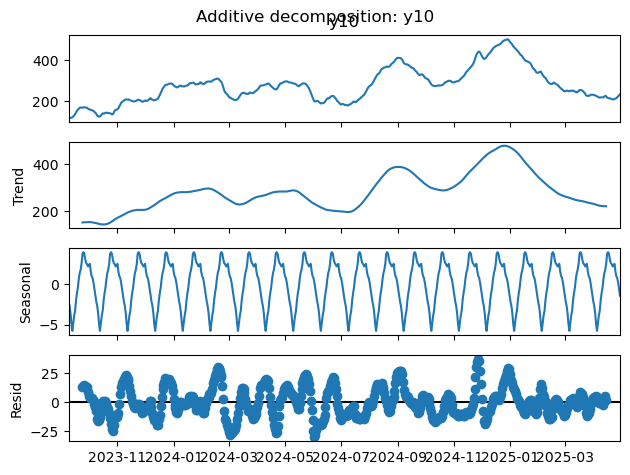

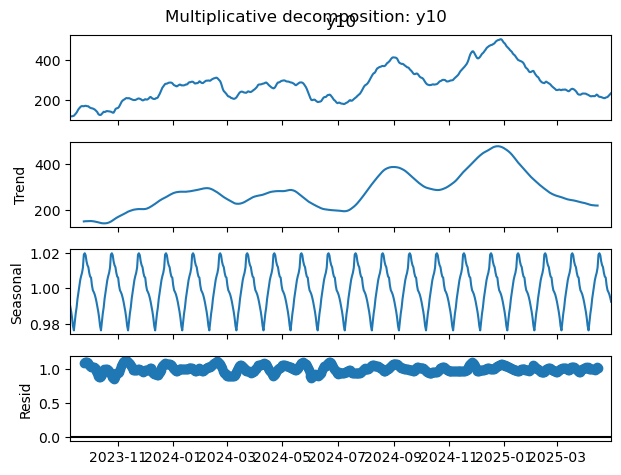

In [43]:
#Seasonal Decomposition
for col in df.columns:
    # additive
    decomp_add = seasonal_decompose(df[col], model='additive', period=30)
    decomp_add.plot()
    plt.suptitle(f'Additive decomposition: {col}')
    plt.show()
    
    # multiplicative
    decomp_mul = seasonal_decompose(df[col], model='multiplicative', period=30)
    decomp_mul.plot()
    plt.suptitle(f'Multiplicative decomposition: {col}')
    plt.show()

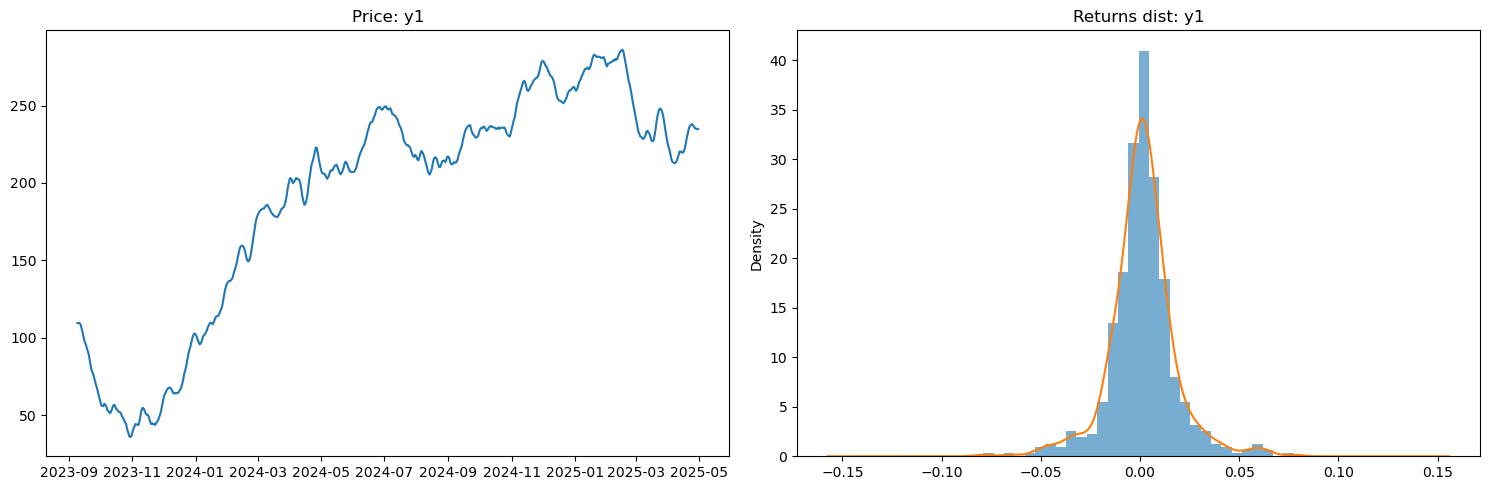

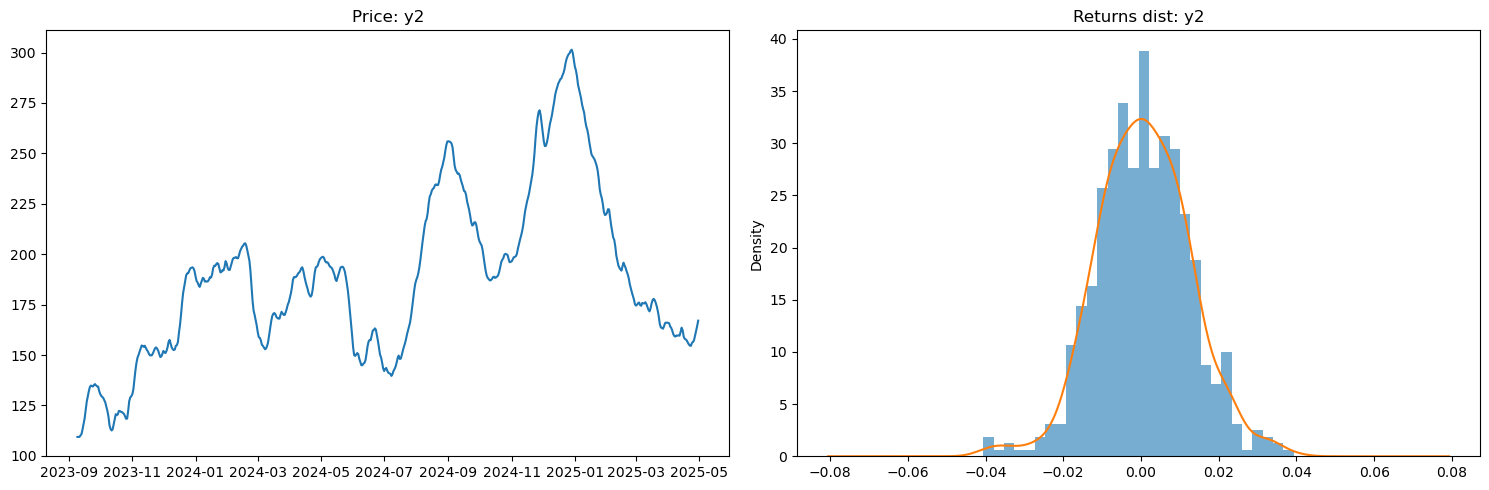

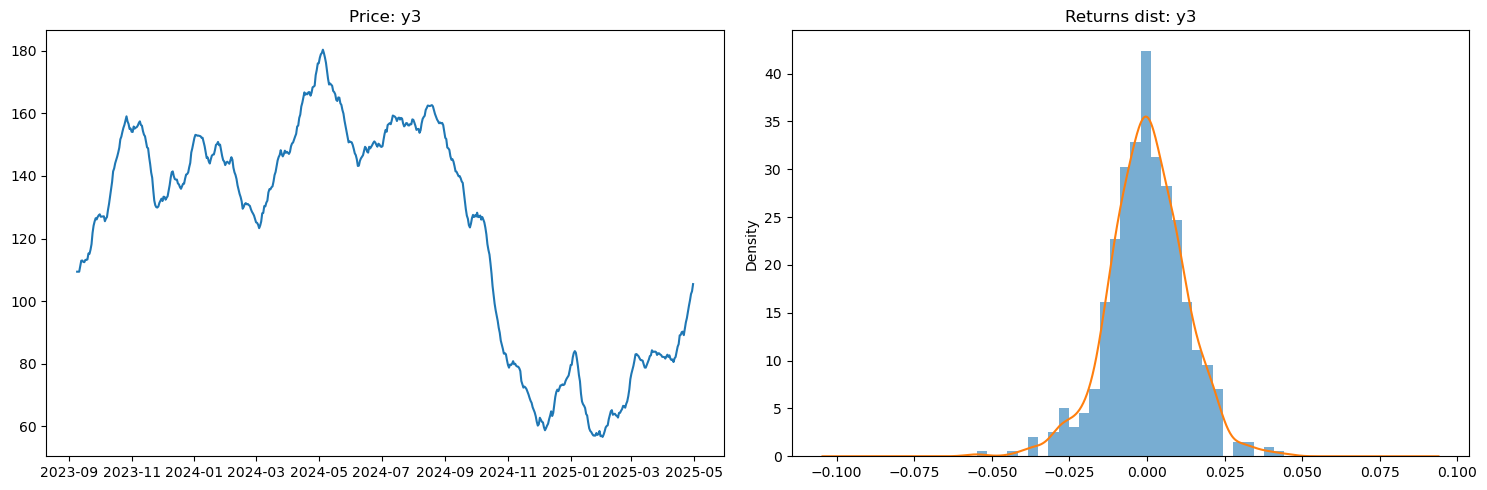

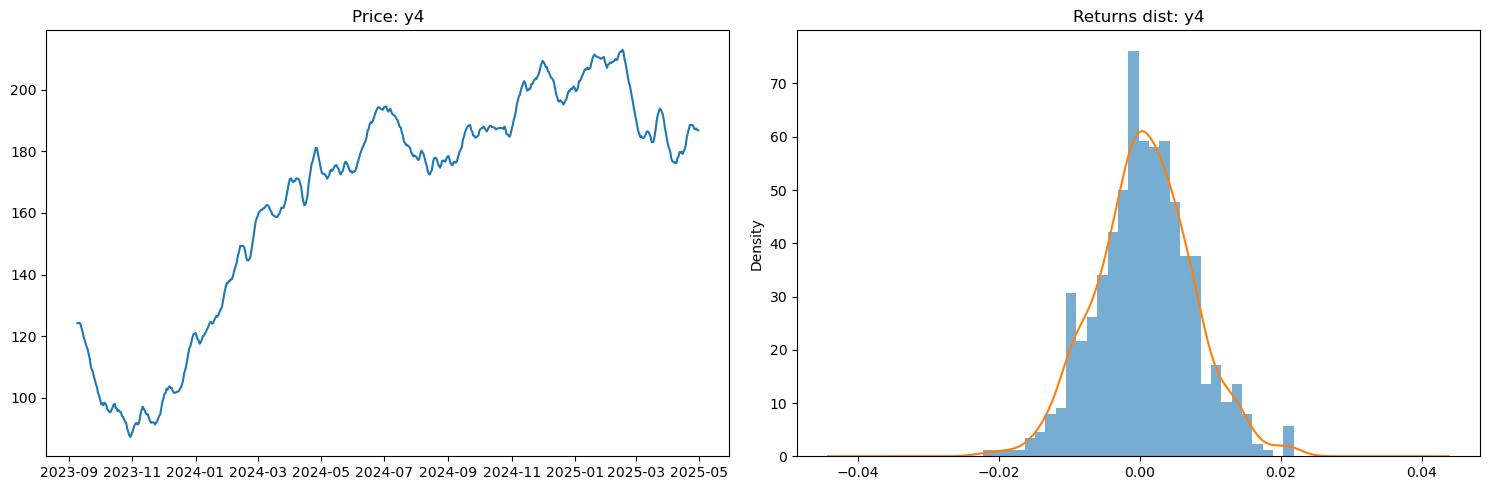

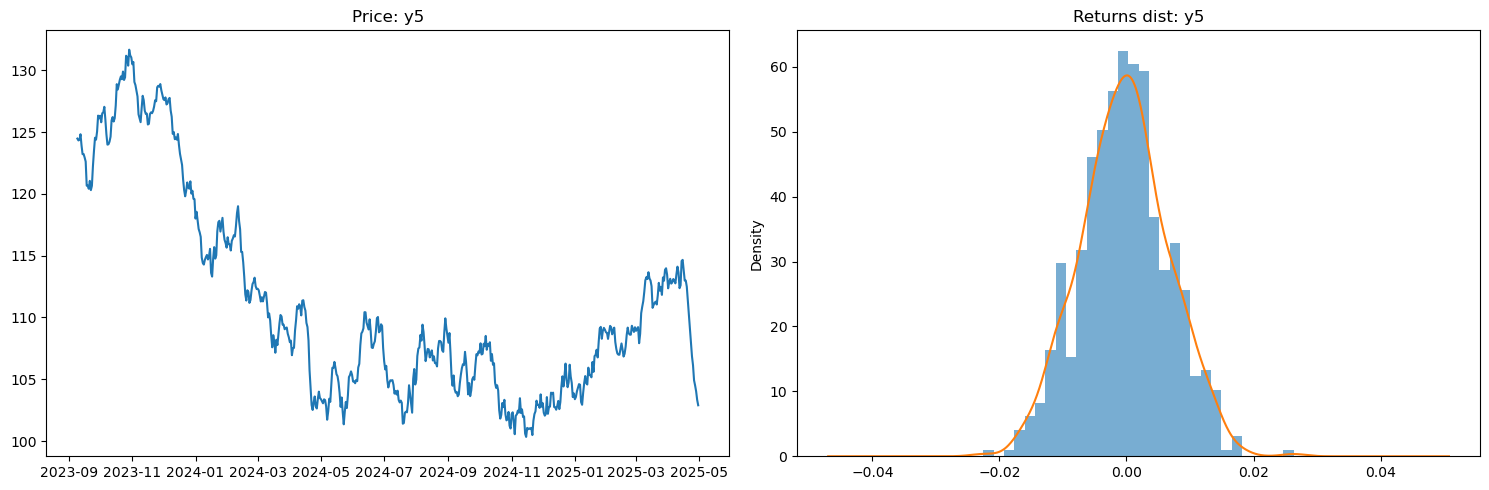

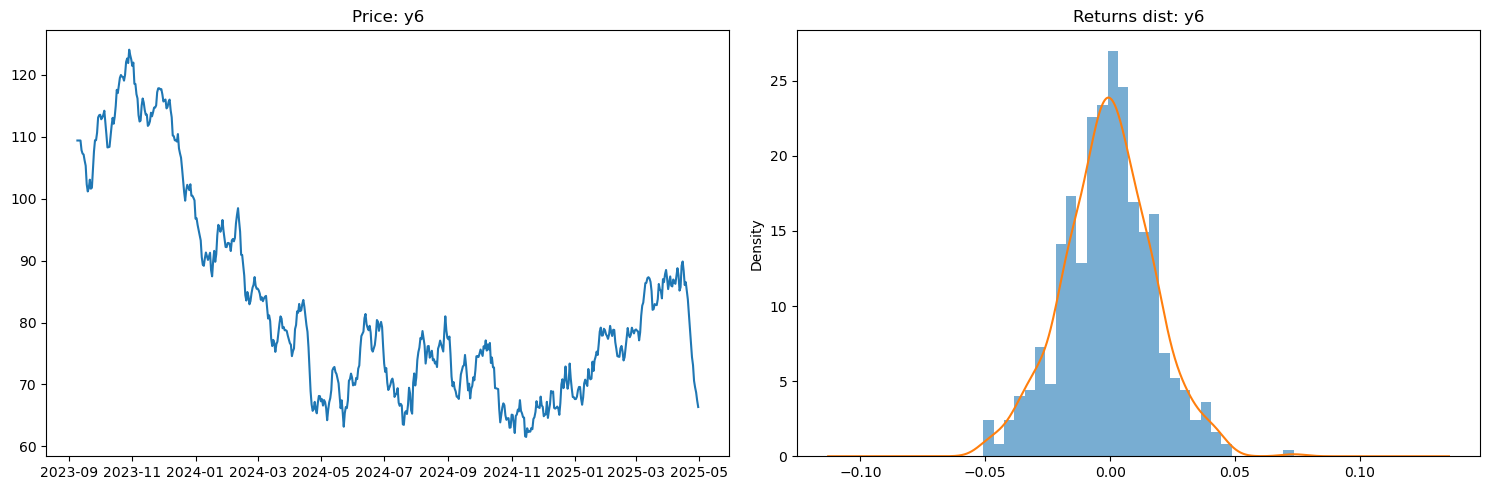

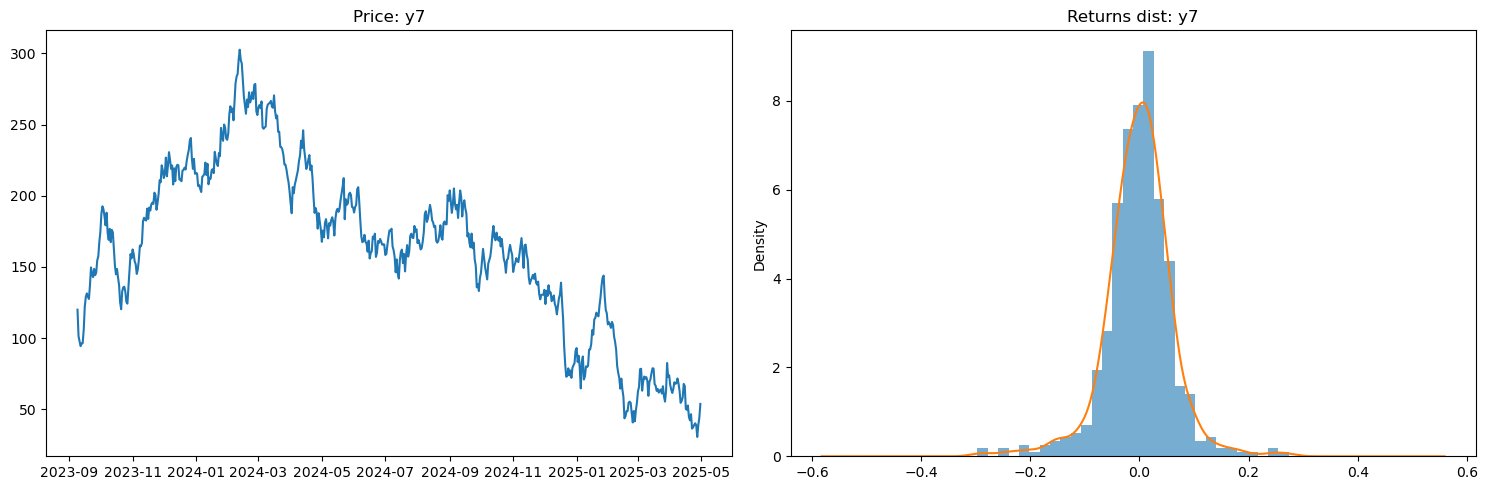

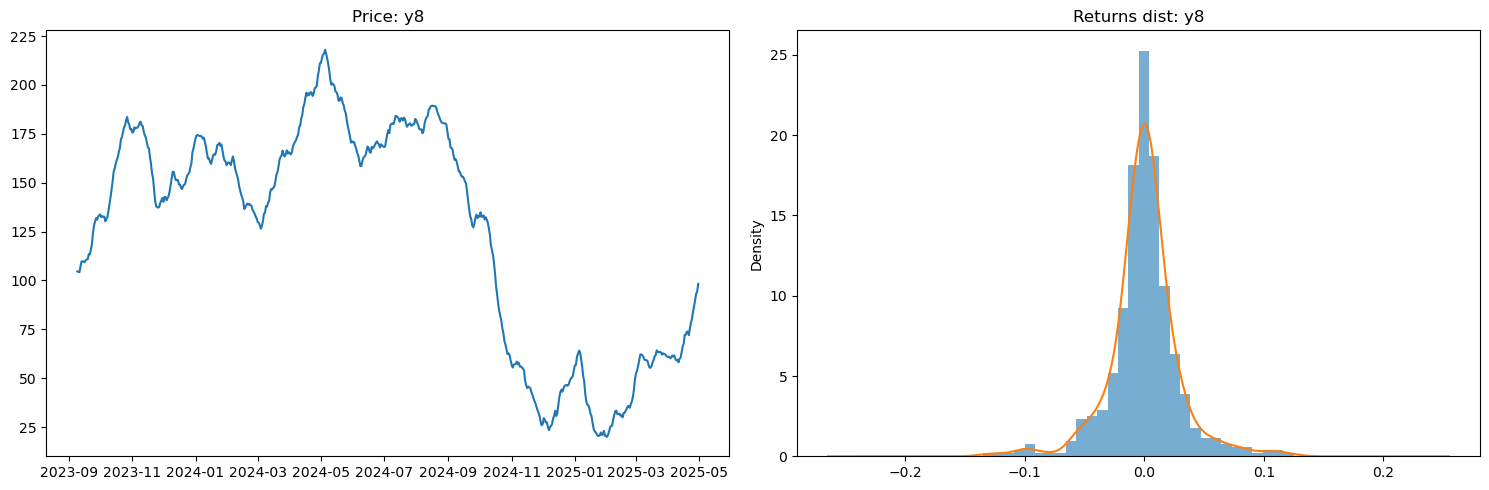

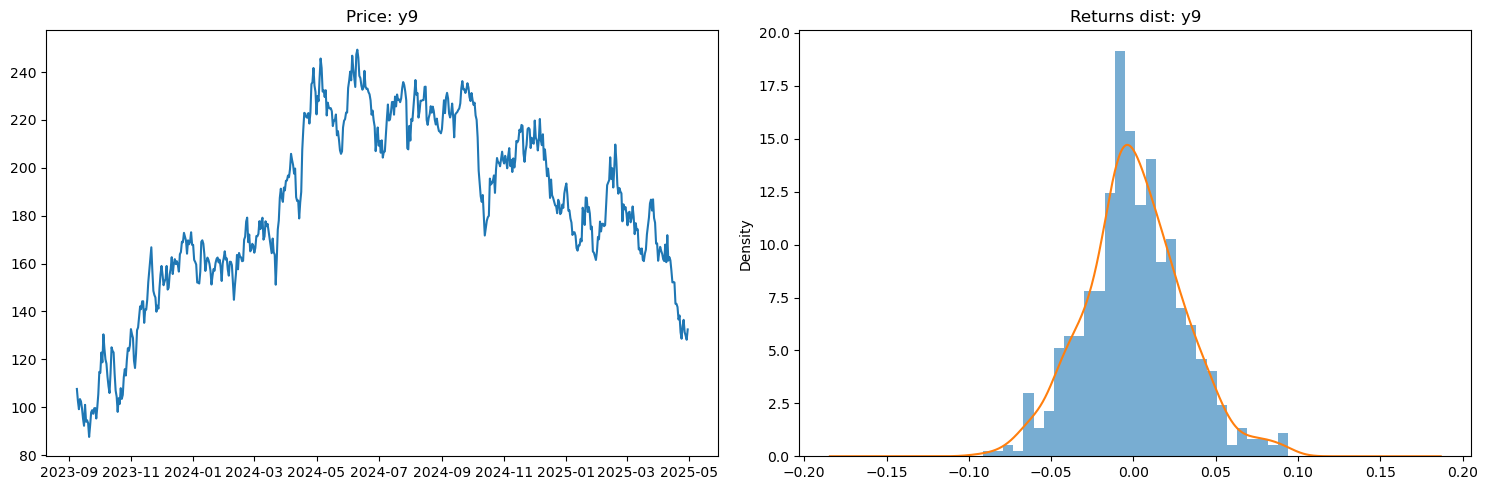

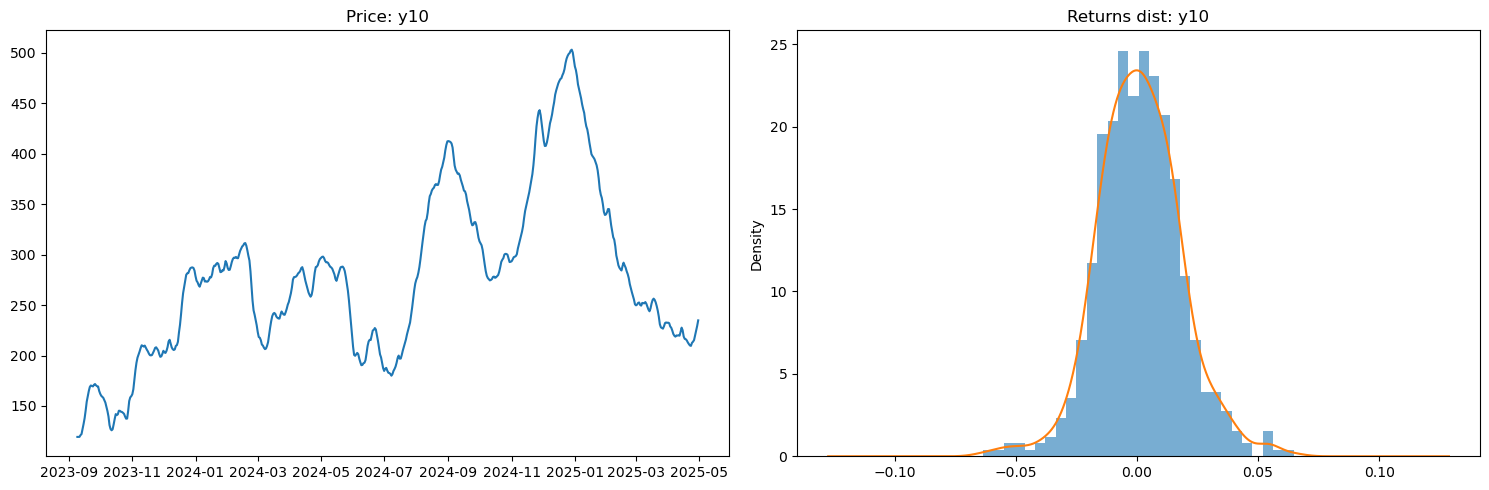

In [44]:
# Compute log-returns
returns = np.log(df) - np.log(df.shift(1))
returns = returns.dropna()

# Plot price vs returns
for col in df.columns:
    plt.figure(figsize=(15,5))
    plt.subplot(1,2,1)
    plt.plot(df.index, df[col])
    plt.title(f'Price: {col}')
    plt.subplot(1,2,2)
    plt.hist(returns[col], bins=30, density=True, alpha=0.6)
    returns[col].plot(kind='kde')
    plt.title(f'Returns dist: {col}')
    plt.tight_layout()
    plt.show()

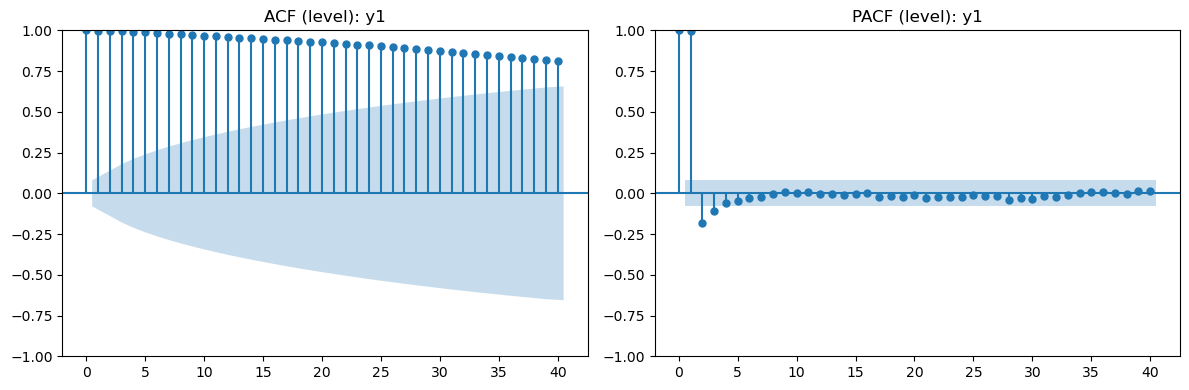

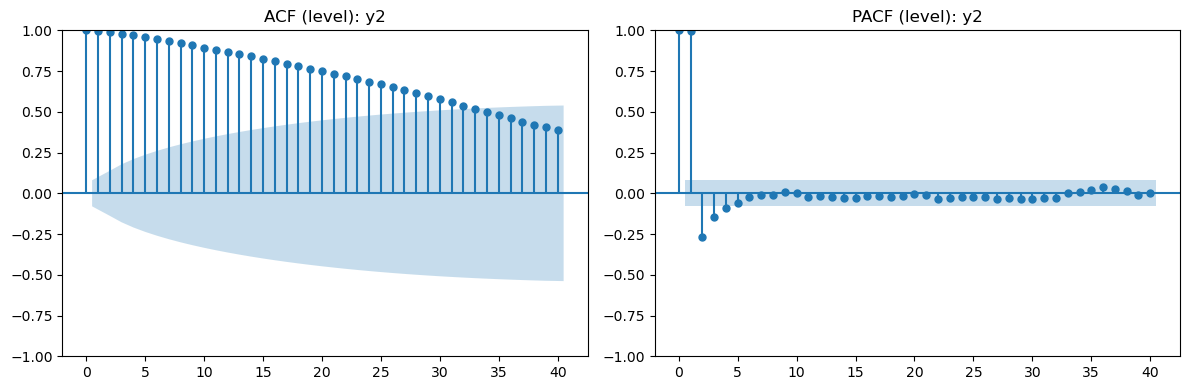

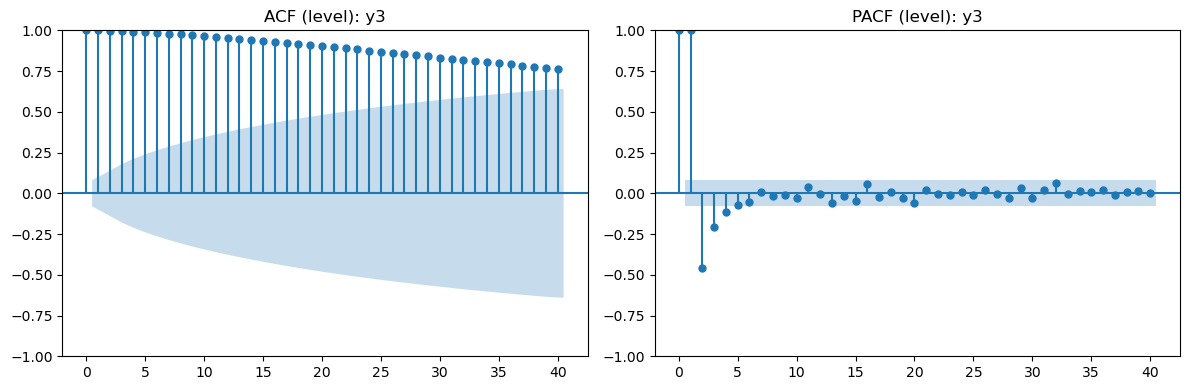

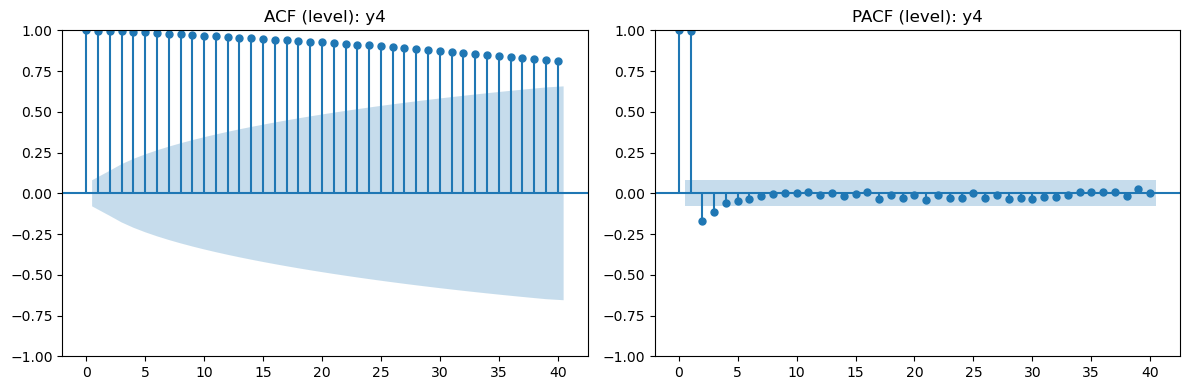

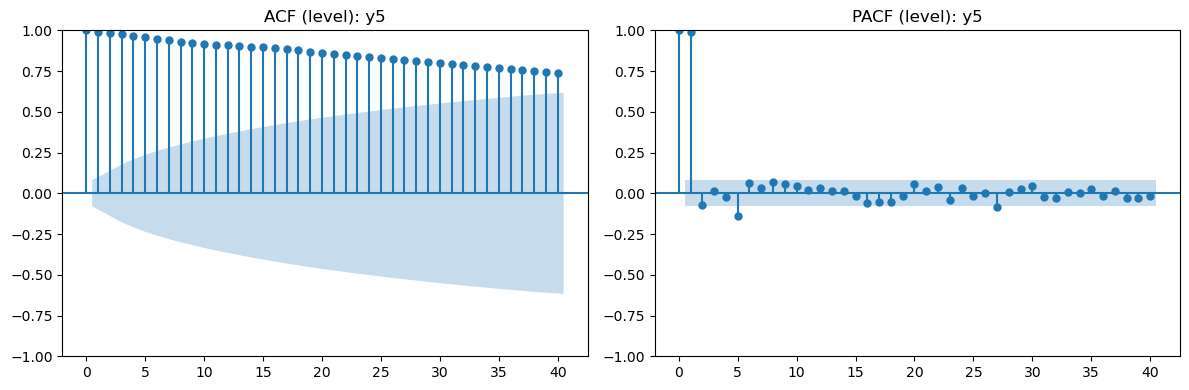

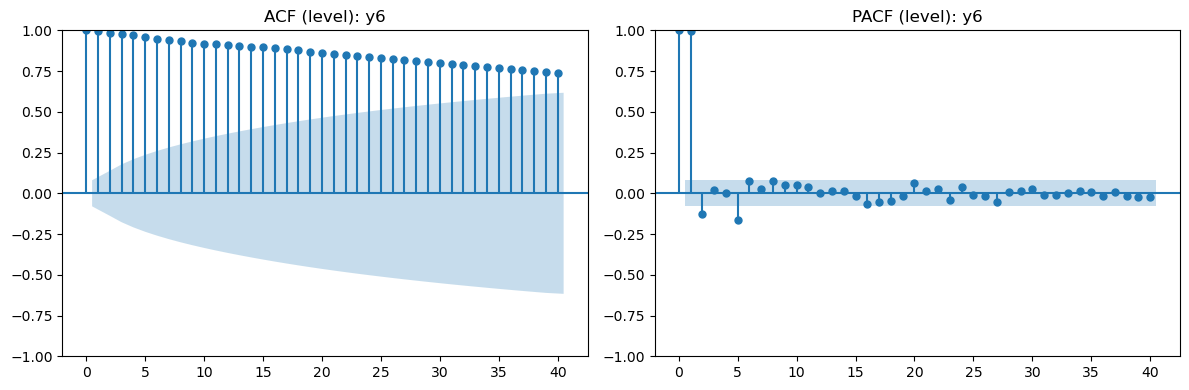

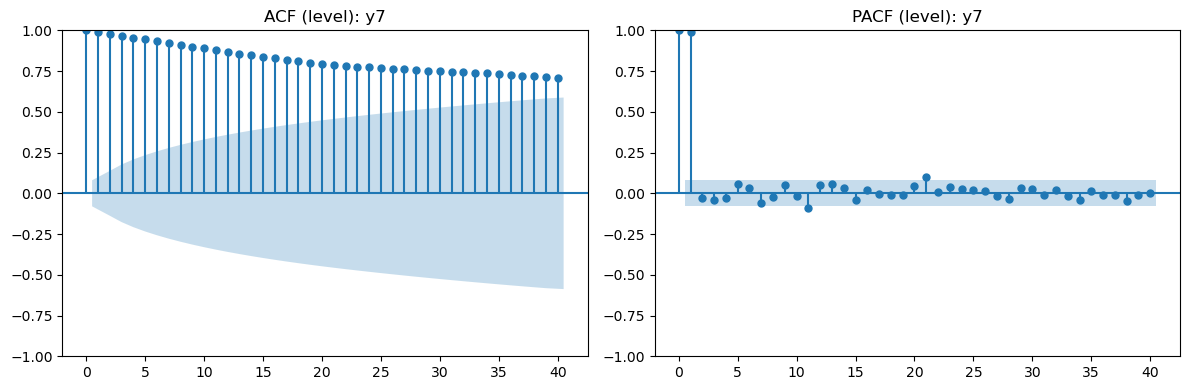

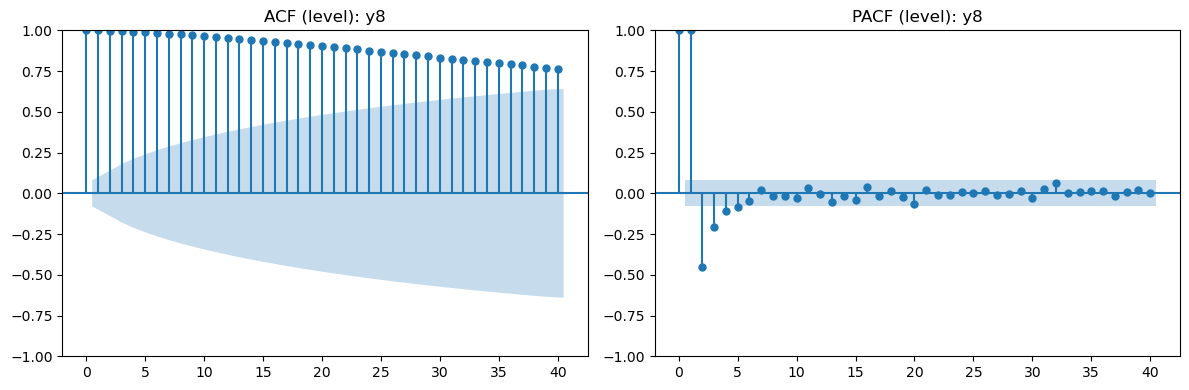

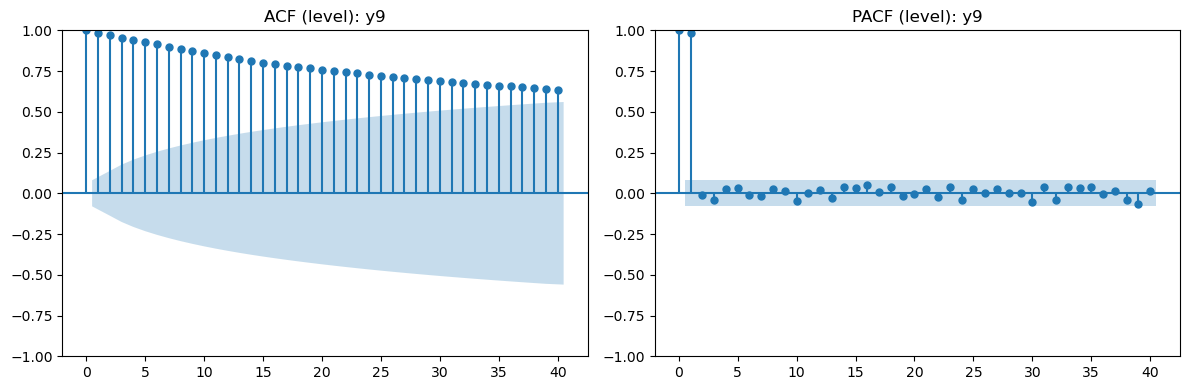

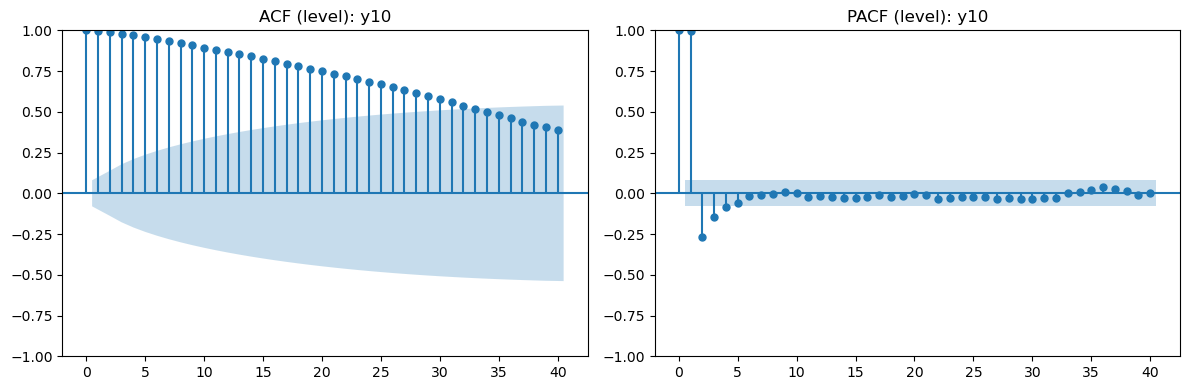

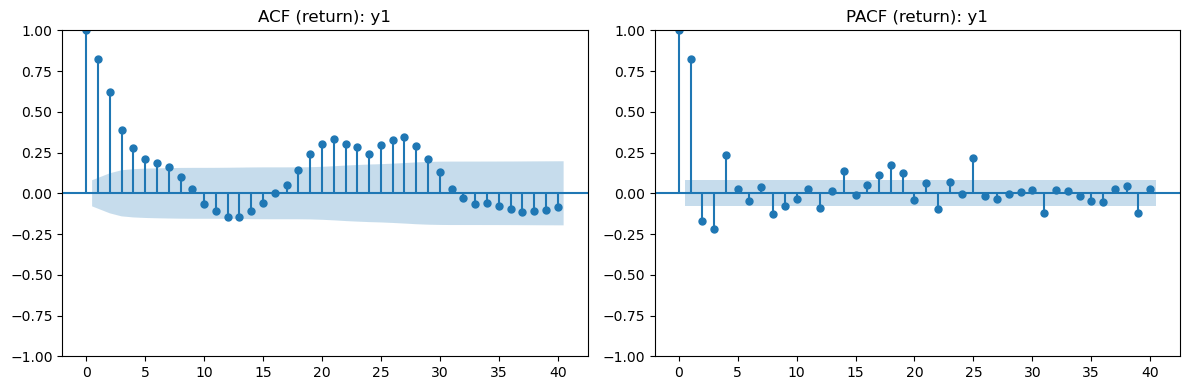

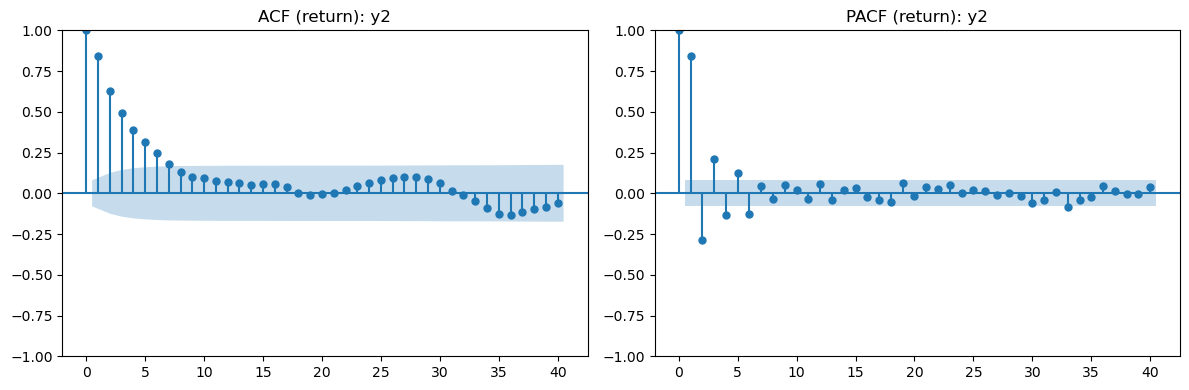

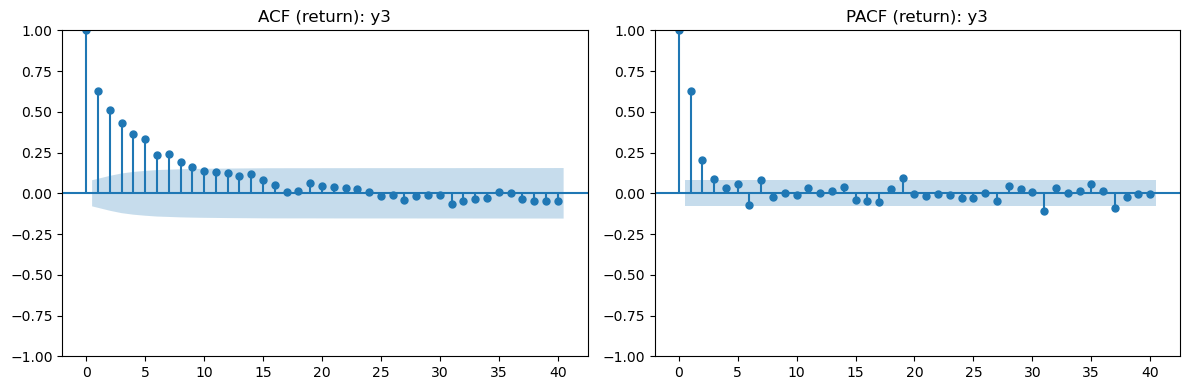

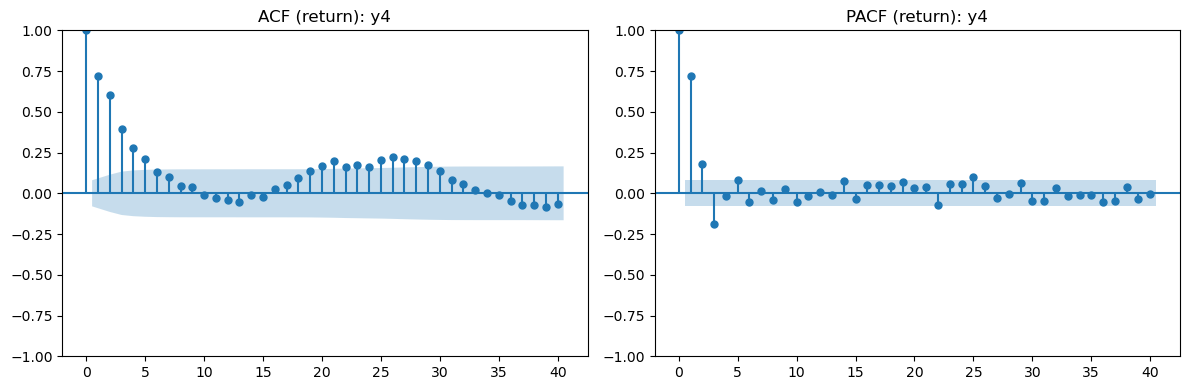

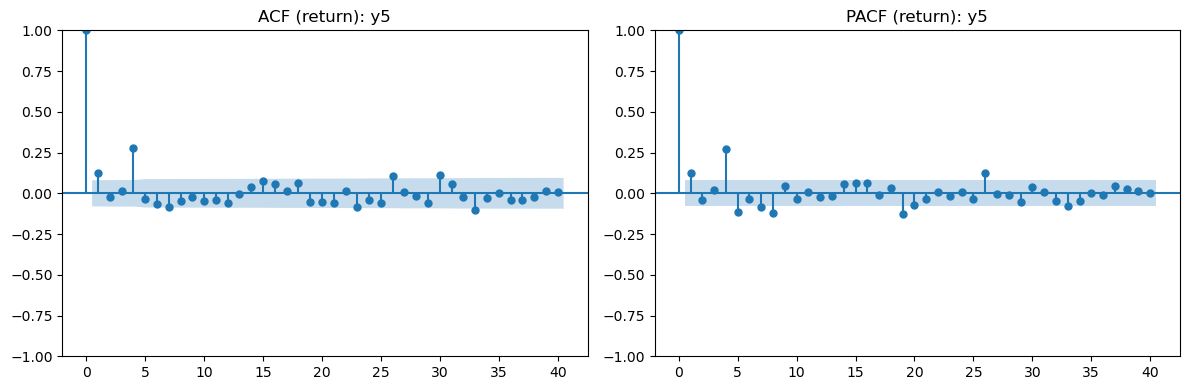

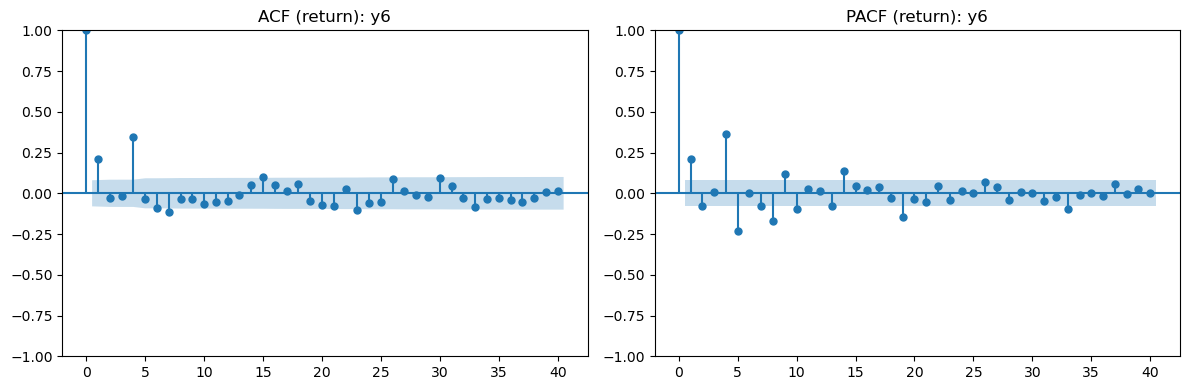

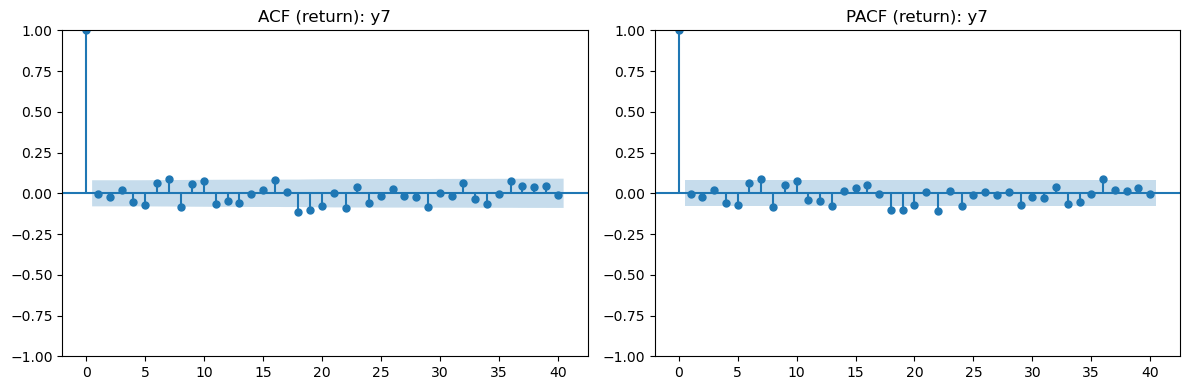

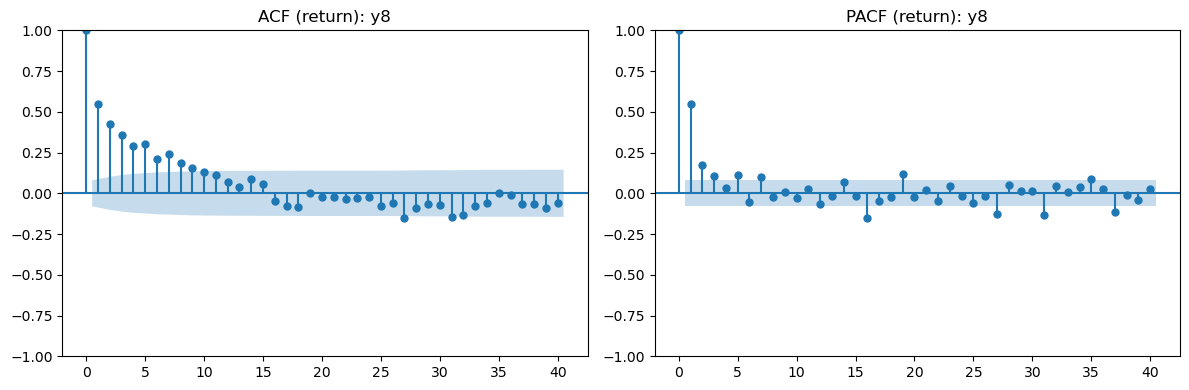

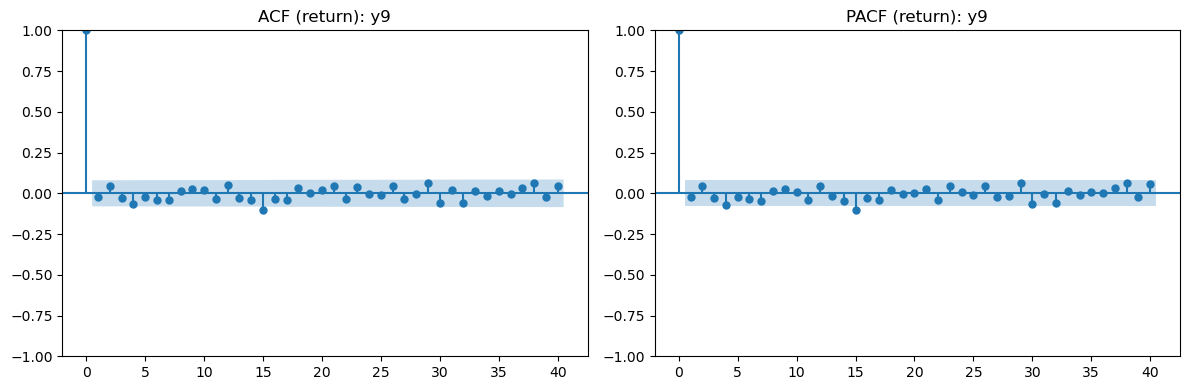

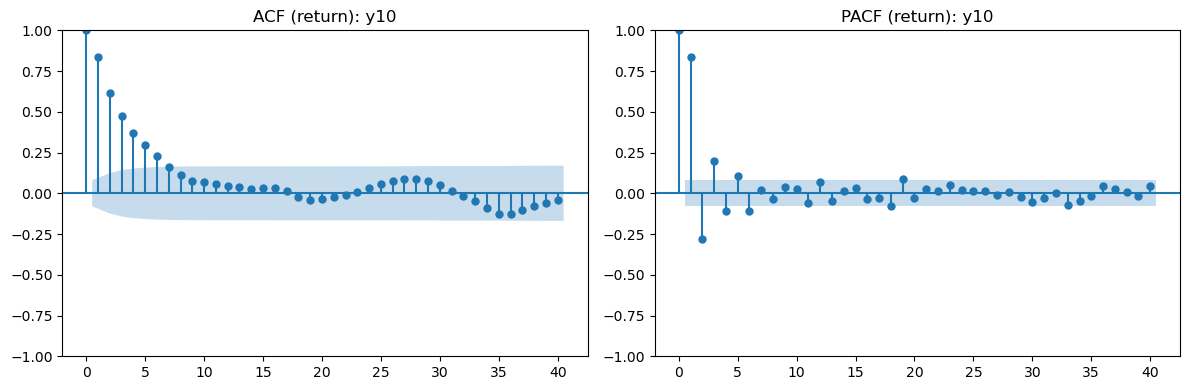

In [45]:
# Plot ACF and PACF
#levels
for col in df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(df[col].dropna(), lags=40, ax=axes[0], title=f'ACF (level): {col}')
    plot_pacf(df[col].dropna(), lags=40, ax=axes[1], title=f'PACF (level): {col}')
    plt.tight_layout()
    plt.show()

#returns
for col in returns.columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    plot_acf(returns[col], lags=40, ax=axes[0], title=f'ACF (return): {col}')
    plot_pacf(returns[col], lags=40, ax=axes[1], title=f'PACF (return): {col}')
    plt.tight_layout()
    plt.show()

In [46]:
#ADF kPSS tests
# Suppress that interpolation warning
warnings.filterwarnings("ignore", category=InterpolationWarning)

# ADF & KPSS on levels
adf_levels  = {col: adfuller(df[col].dropna())             for col in df.columns}
kpss_levels = {col: kpss(df[col].dropna(), nlags="auto")   for col in df.columns}

# Compute log-returns first
import numpy as np
returns = np.log(df) - np.log(df.shift(1))
returns = returns.dropna()

# ADF & KPSS on returns
adf_returns  = {col: adfuller(returns[col])                for col in returns.columns}
kpss_returns = {col: kpss(returns[col], nlags="auto")      for col in returns.columns}

# Pretty‐print results
def print_test_results(test_results, test_name, kpss=False):
    print(f"\n{test_name} Test Results:")
    for col, result in test_results.items():
        stat, pval = result[0], result[1]
        crit = result[4] if not kpss else result[3]
        print(f"{col}: stat={stat:.4f}, p={pval:.4f}, crit_vals={crit}")
    print()

print_test_results(adf_levels,  "ADF (level)")
print_test_results(kpss_levels, "KPSS (level)",  kpss=True)
print_test_results(adf_returns, "ADF (return)")
print_test_results(kpss_returns,"KPSS (return)", kpss=True)


ADF (level) Test Results:
y1: stat=-1.3506, p=0.6057, crit_vals={'1%': -3.4414821678603946, '5%': -2.8664511716874657, '10%': -2.5693855271473716}
y2: stat=-2.2330, p=0.1945, crit_vals={'1%': -3.441444394224128, '5%': -2.8664345376276454, '10%': -2.569376663737217}
y3: stat=-1.3467, p=0.6076, crit_vals={'1%': -3.441388211993052, '5%': -2.8664097967491498, '10%': -2.569363480686392}
y4: stat=-1.1376, p=0.6999, crit_vals={'1%': -3.4413696108194607, '5%': -2.8664016052801906, '10%': -2.569359115918202}
y5: stat=-1.4830, p=0.5419, crit_vals={'1%': -3.4414632489439714, '5%': -2.866442840548375, '10%': -2.5693810879206143}
y6: stat=-1.6915, p=0.4355, crit_vals={'1%': -3.4416749612171467, '5%': -2.8665360672844318, '10%': -2.5694307639714626}
y7: stat=-1.0609, p=0.7304, crit_vals={'1%': -3.44152019959894, '5%': -2.8664679191981297, '10%': -2.569394451038919}
y8: stat=-1.2266, p=0.6620, crit_vals={'1%': -3.4414256033746606, '5%': -2.8664262627821473, '10%': -2.569372254520843}
y9: stat=-2.033

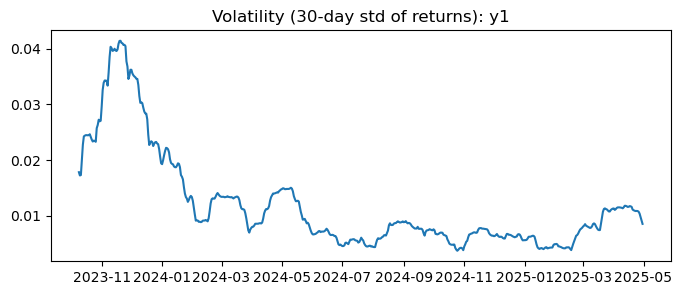

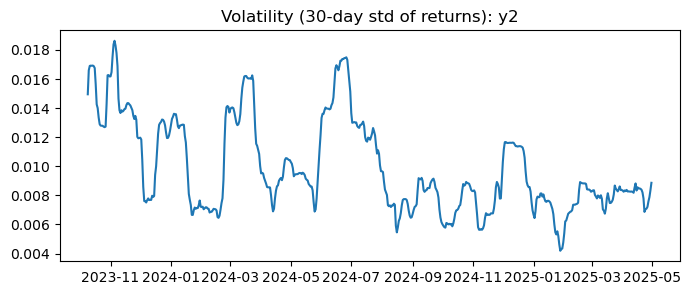

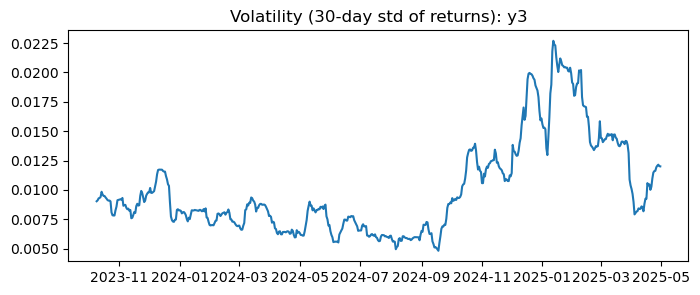

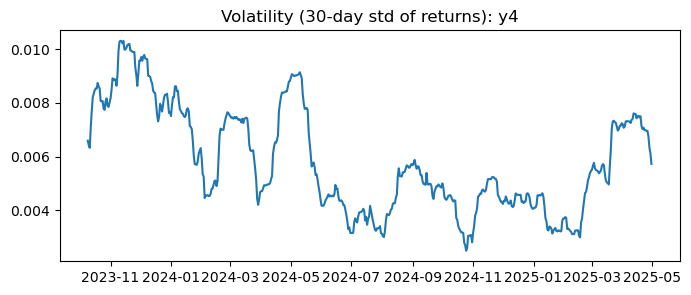

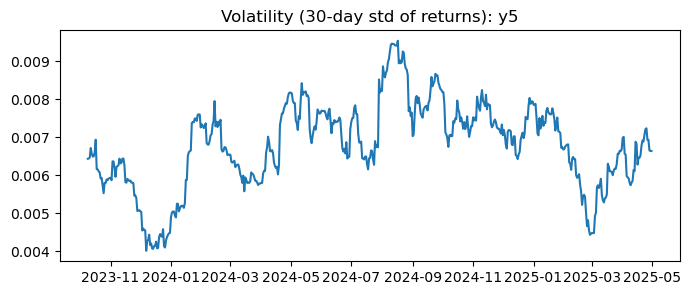

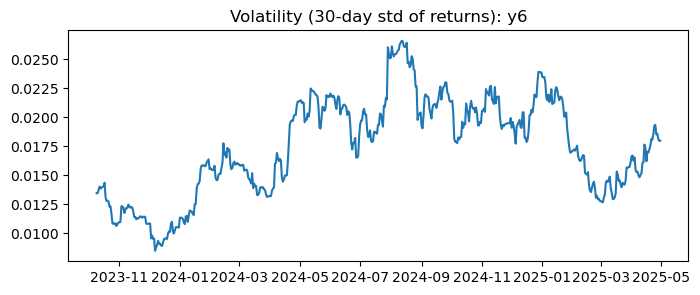

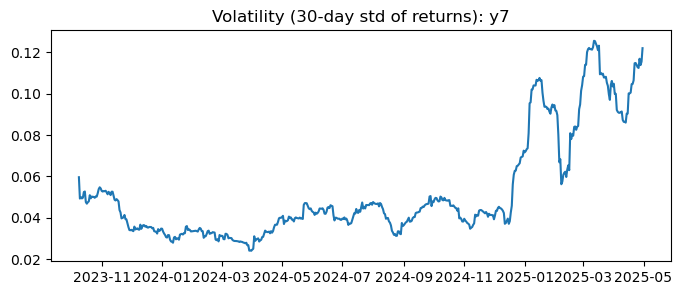

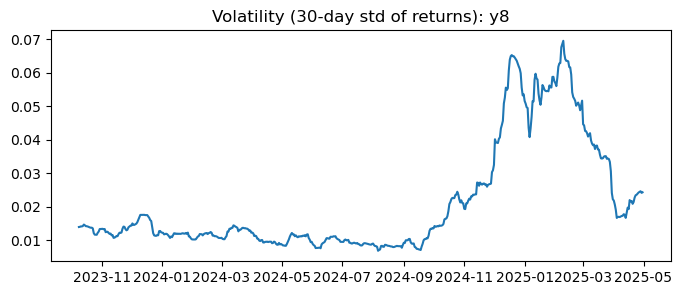

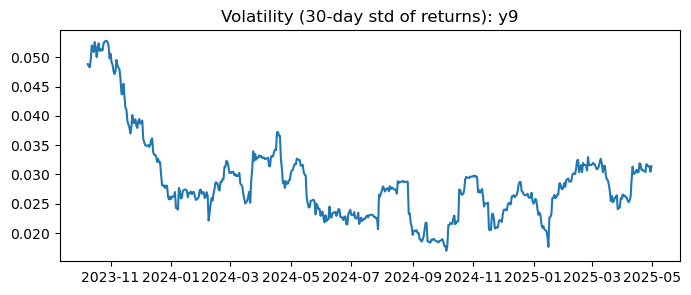

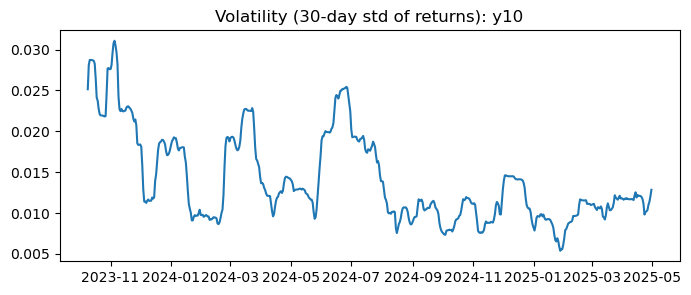

In [47]:
#volatility clustering
# Compute 30-day rolling std of returns
volatility = returns.rolling(window=30).std()

# Plot
for col in volatility.columns:
    plt.figure(figsize=(8,3))
    plt.plot(volatility.index, volatility[col])
    plt.title(f'Volatility (30-day std of returns): {col}')
    plt.show()

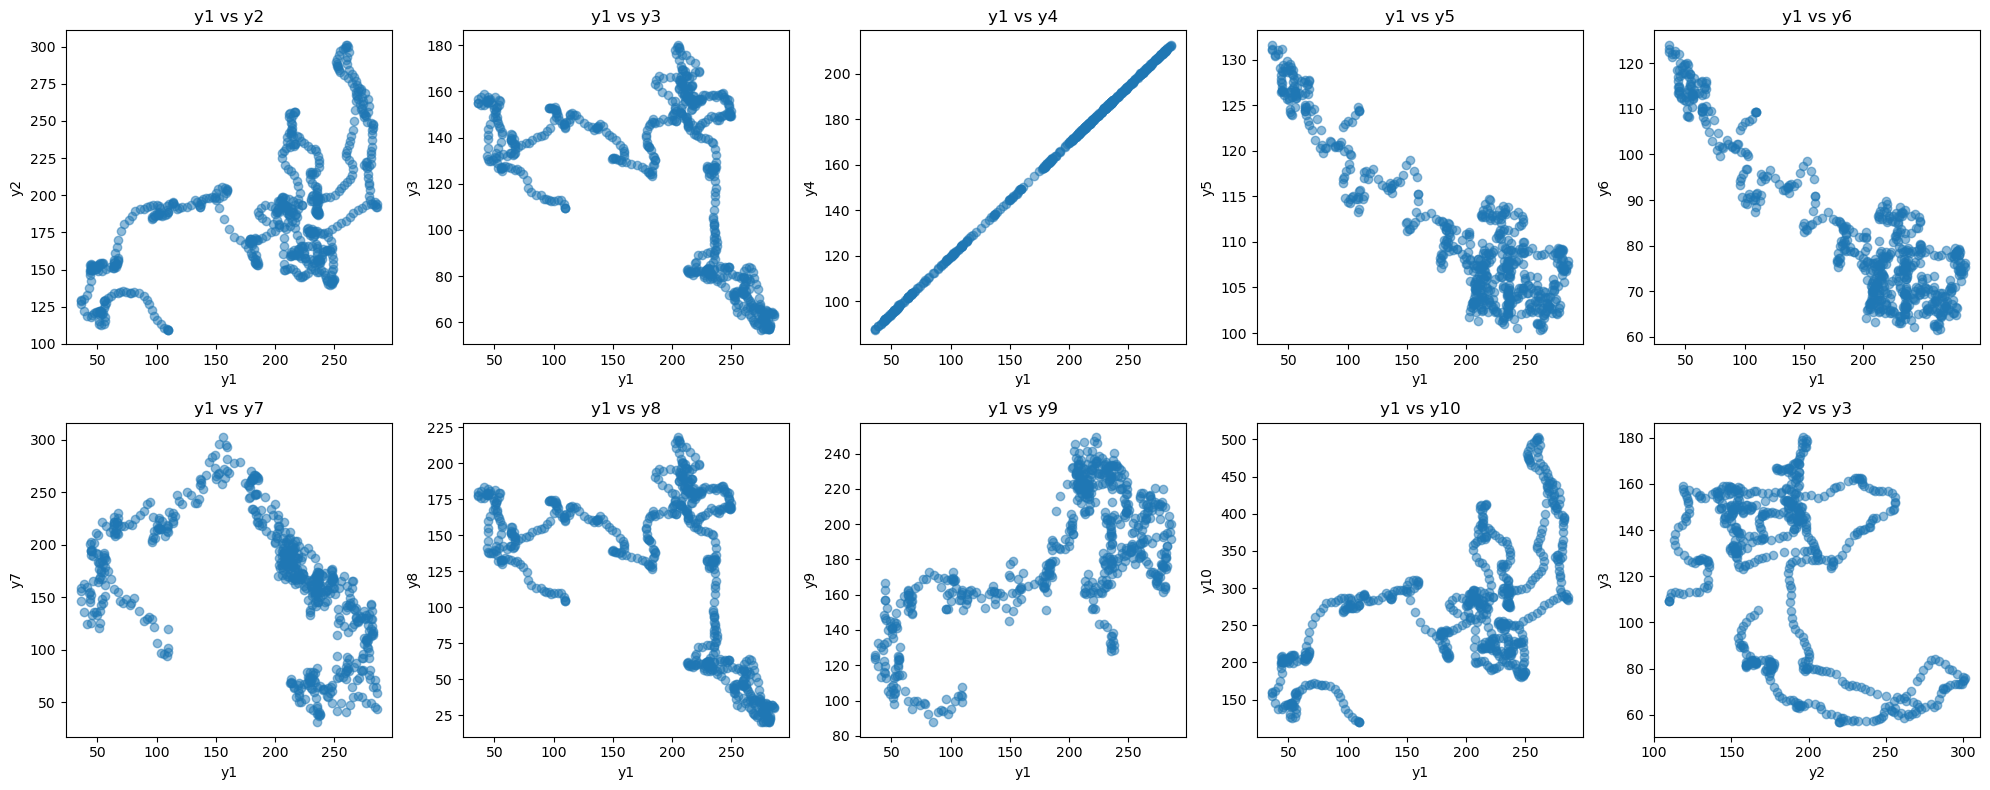

In [50]:
#pairwise correlation
# Select the first 10 pairwise combinations
pairs = list(itertools.combinations(df.columns, 2))[:10]

# Create a 2×5 grid of subplots
fig, axes = plt.subplots(2, 5, figsize=(20, 8))
axes = axes.flatten()

for ax, (x, y) in zip(axes, pairs):
    ax.scatter(df[x], df[y], alpha=0.5)
    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'{x} vs {y}')

plt.tight_layout()
plt.show()

We see that y1/y4 has the strongest pairwise correlation